In [1]:
# ========================
# 1. Import Dependencies
# ========================
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, cohen_kappa_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, GlobalAveragePooling2D, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# ========================
# 2. Configuration Settings
# ========================
FRAME_SIZE = (160, 160)
SEQUENCE_LENGTH = 12
BATCH_SIZE = 2
EPOCHS = 10
DATASET_PATH = r'C:\Users\ashof\deepfake project\deepfake_dataset\Celeb-DF'

In [3]:
# ========================
# 3. Face Detection Utility
# ========================
def detect_and_crop_face(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if len(faces) > 0:
        x, y, w, h = faces[0]
        face = frame[y:y+h, x:x+w]
        return cv2.resize(face, FRAME_SIZE)
    return cv2.resize(frame, FRAME_SIZE)


In [4]:
# ========================
# 4. Frame Extraction
# ========================
def extract_frames(video_path, max_frames=SEQUENCE_LENGTH):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while len(frames) < max_frames and cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        face = detect_and_crop_face(frame)
        face = image.img_to_array(face) / 255.0
        frames.append(face)
    cap.release()
    while len(frames) < max_frames:
        frames.append(np.zeros_like(frames[0]))
    return np.array(frames)

In [5]:
# ========================
# 5. Feature Extractor - ResNet50 (Fine-tuned)
# ========================
def build_feature_extractor():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*FRAME_SIZE, 3))
    for layer in base_model.layers[-40:]:  # Fine-tune last 40 layers
        layer.trainable = True
    x = GlobalAveragePooling2D()(base_model.output)
    return Model(inputs=base_model.input, outputs=x)

In [6]:
# ========================
# 6. LSTM Classifier Model
# ========================
def build_deepfake_model(feature_extractor):
    video_input = Input(shape=(SEQUENCE_LENGTH, *FRAME_SIZE, 3))
    x = TimeDistributed(feature_extractor)(video_input)
    x = LSTM(64)(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=video_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:
# ========================
# 7. Load Video Paths and Labels
# ========================
def load_video_paths(dataset_path):
    video_paths, labels = [], []
    real_folders = ['Celeb-real', 'YouTube-real']
    fake_folders = ['Celeb-synthesis']

    # Label 0 = REAL
    for folder in real_folders:
        full_path = os.path.join(dataset_path, folder)
        for file in os.listdir(full_path):
            if file.endswith('.mp4'):
                video_paths.append(os.path.join(full_path, file))
                labels.append(0)

    # Label 1 = FAKE
    for folder in fake_folders:
        full_path = os.path.join(dataset_path, folder)
        for file in os.listdir(full_path):
            if file.endswith('.mp4'):
                video_paths.append(os.path.join(full_path, file))
                labels.append(1)

    return video_paths, labels


In [8]:
# ========================
# 8. Data Generator
# ========================
class VideoDataGenerator(Sequence):
    def __init__(self, video_paths, labels, batch_size=BATCH_SIZE, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.video_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.video_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = [], []
        for path, label in zip(batch_paths, batch_labels):
            frames = extract_frames(path)
            X.append(frames)
            y.append(label)
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.video_paths, self.labels))
            np.random.shuffle(combined)
            self.video_paths, self.labels = zip(*combined)

In [9]:
# ========================
# 9. Load Data and Build Model
# ========================
print("Loading video dataset...")
video_paths, labels = load_video_paths(DATASET_PATH)
train_paths, test_paths, train_labels, test_labels = train_test_split(video_paths, labels, test_size=0.2, stratify=labels, random_state=42)
train_gen = VideoDataGenerator(train_paths, train_labels)
test_gen = VideoDataGenerator(test_paths, test_labels, shuffle=False)

print("Initializing model...")
feature_extractor = build_feature_extractor()
model = build_deepfake_model(feature_extractor)
model.summary()


Loading video dataset...
Initializing model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 12, 160, 160, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 12, 2048)            │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │         540,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,133,121 (92.06 MB)

 Trainable params: 24,079,873 (91.86 MB)

 Non-trainable params: 53,248 (208.00 KB)

In [10]:
# ========================
# 10. Train Model
# ========================
cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
cw_dict = {i: cw[i] for i in range(len(cw))}
early_stop = EarlyStopping(patience=2, restore_best_weights=True)

print("Training the model...")
history = model.fit(train_gen, validation_data=test_gen, epochs=EPOCHS, class_weight=cw_dict, callbacks=[early_stop])


Training the model...
Epoch 1/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 1420s 3s/step - accuracy: 0.5547 - loss: 0.6861 - val_accuracy: 0.5436 - val_loss: 0.7289
Epoch 2/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 1328s 3s/step - accuracy: 0.6294 - loss: 0.6675 - val_accuracy: 0.7012 - val_loss: 0.7244
Epoch 3/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 1318s 3s/step - accuracy: 0.5925 - loss: 0.6913 - val_accuracy: 0.6971 - val_loss: 0.7966
Epoch 4/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 1476s 3s/step - accuracy: 0.6136 - loss: 0.6681 - val_accuracy: 0.6680 - val_loss: 0.6346
Epoch 5/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 1485s 3s/step - accuracy: 0.6106 - loss: 0.6390 - val_accuracy: 0.7095 - val_loss: 0.5780
Epoch 6/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 1432s 3s/step - accuracy: 0.5120 - loss: 0.7097 - val_accuracy: 0.6058 - val_loss: 0.6833
Epoch 7/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 1302s 3s/step - accuracy: 0.5569 - loss: 0.6936 - val_accuracy: 0.7137 - val_loss: 0.5712
Epoch 8/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 1305s 3s/step - accuracy: 0.

In [11]:
# ========================
# 11. Save Model
# ========================
model.save("deepfake_detector_resnet_finetuned.keras")
print("Model saved successfully.")


Model saved successfully.


In [12]:
# ========================
# 12. Evaluate Model
# ========================
y_true, y_pred, y_prob = [], [], []
for X_batch, y_batch in test_gen:
    prob = model.predict(X_batch).flatten()
    preds = (prob > 0.5).astype(int)
    y_true.extend(y_batch)
    y_pred.extend(preds)
    y_prob.extend(prob)
    if len(y_true) >= len(test_labels):
        break

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["REAL", "FAKE"]))
print("AUC Score:", round(roc_auc_score(y_true, y_prob), 2))
print("Cohen's Kappa:", round(cohen_kappa_score(y_true, y_pred), 2))

sensitivity = recall_score(y_true, y_pred, pos_label=1)
cm = confusion_matrix(y_true, y_pred)
specificity = cm[0][0] / (cm[0][0] + cm[0][1])
youden_j = sensitivity + specificity - 1
print(f"Youden's J statistic: {youden_j:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

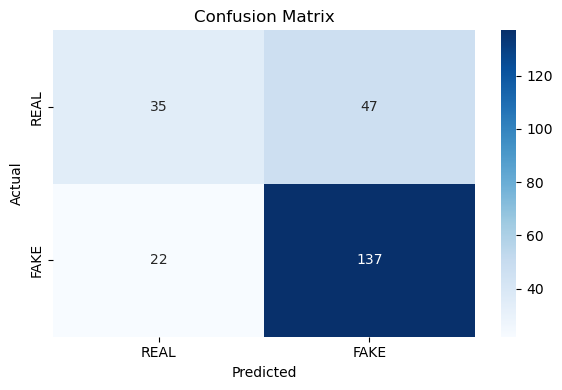

In [13]:
# ========================
# 13. Confusion Matrix Plot
# ========================
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "FAKE"], yticklabels=["REAL", "FAKE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

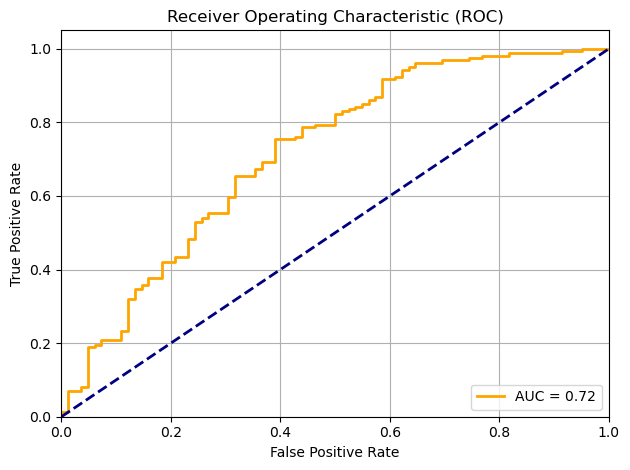

In [14]:
# ========================
# 14. ROC Curve
# ========================
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# ========================
# 15. Predict Custom Video
# ========================
def predict_custom_video(video_path):
    custom_video = extract_frames(video_path, max_frames=SEQUENCE_LENGTH)
    custom_video = np.expand_dims(custom_video, axis=0)
    pred = model.predict(custom_video)[0][0]
    label = "REAL" if pred < 0.5 else "FAKE"
    confidence = (1 - pred if label == "REAL" else pred) * 100
    print(f"Prediction: {label} ({confidence:.2f}%)")

# Now call it like this AFTER defining it:
predict_custom_video(r"C:\Users\ashof\deepfake project\deepfake_dataset\Celeb-DF\Celeb-synthesis\id0_id6_0007.mp4")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Prediction: FAKE (65.91%)


In [31]:
# ResNet50 notebook
np.save("resnet_probs.npy", model.predict(test_gen, verbose=0).flatten())
np.save("resnet_preds.npy", (model.predict(test_gen) > 0.5).astype(int).flatten())


121/121 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step
